In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

feature_type_list_long = ['gabor_solo_ridge_12ori_8sf',\
                          'all_coco', \
                          'alexnet_all_conv_pca']
feature_type_list = ['gabor','coco', 'alexnet']

n_models = len(feature_type_list)
out_list = []
for fi, fitting_type in enumerate(feature_type_list_long):

    out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                      n_from_end=0, verbose=False) \
           for ss in subjects]
    out_list.append(out)
    
out = out_list
    
fig_save_folder=None

# create ROI definitions
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

#### Plot Gabor, COCO-all, and AlexNet-concat

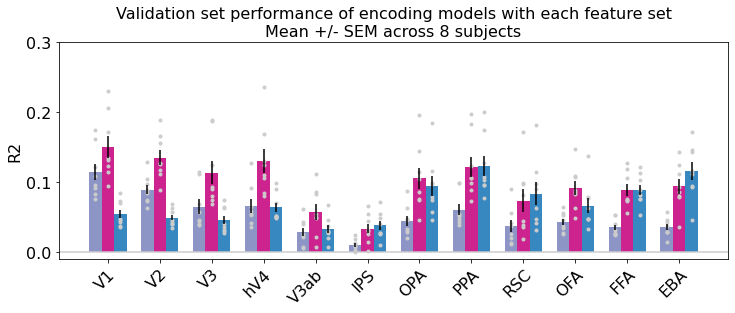

In [4]:
mm2plot = [0,2,1]

colors = cm.BuPu(np.linspace(0,1,3))[1:4,:]
sem_colors = cm.Blues(np.linspace(0,1,4))[2:3,:]
dnn_colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]
colors = np.concatenate([colors[0:1,:], dnn_colors, sem_colors], axis=0)

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = summary_plots.get_noise_ceiling(out[fi][si])
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.24;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4))


fn2save = os.path.join(default_paths.fig_path, 'all_models_R2.pdf')
plt.savefig(fn2save)